In [1]:
import util
from forward import solve_forward
from simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# to load large .mat files
import mat73
import random
from net import EEG_CNN

2021-12-11 15:37:37.827795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 15:37:37.827818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Train the CNN

In [2]:
eeg_topos = mat73.loadmat('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_1/eeg_topographies.mat')['eeg_arr']
eeg_topos = eeg_topos.transpose(2, 0, 1)

Text(0.5, 1.0, 'Topography for eeg signal: 34770')

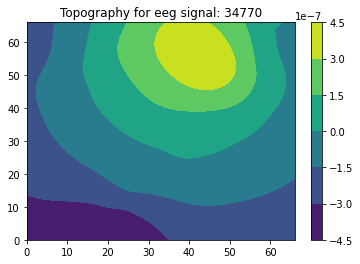

In [3]:
topo_idx = random.randint(0,eeg_topos.shape[0]-1)
topo = eeg_topos[topo_idx,:,:]
plt.contourf(topo, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.draw()
plt.title('Topography for eeg signal: {}'.format(topo_idx+1))

In [4]:
# load previous simulation
sim = util.load_object('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_1/sim_obj_100k.pkl')
# fwd = solve_forward()
# sim = Simulation(fwd=fwd)
# sim.simulate(n_samples=100)

In [5]:
eegcnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

In [6]:
eegcnn.build_model()

2021-12-11 15:54:12.133952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 15:54:12.135241: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 15:54:12.137216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanos): /proc/driver/nvidia/version does not exist
2021-12-11 15:54:12.156836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-11 15:54:13.079470: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 69222400 exceeds 10%

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 8)         80        
                                                                 
 flatten (Flatten)           (None, 33800)             0         
                                                                 
 dense (Dense)               (None, 512)               17306112  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 OutputLayer (Dense)         (None, 50460)             103392540 
                                                                 
Total params: 123,323,244
Trainable params: 123,323,244


In [7]:
eegcnn.fit(patience=35)

Epoch 1/50
800/800 [==============================] - 1354s 2s/step - loss: 0.0091 - MAE: 0.0702 - RMSE: 0.0952 - val_loss: 0.0034 - val_MAE: 0.0401 - val_RMSE: 0.0580 - lr: 0.0750
Epoch 2/50
800/800 [==============================] - 934s 1s/step - loss: 0.0023 - MAE: 0.0282 - RMSE: 0.0484 - val_loss: 0.0019 - val_MAE: 0.0210 - val_RMSE: 0.0431 - lr: 0.0750
Epoch 3/50
800/800 [==============================] - 856s 1s/step - loss: 0.0018 - MAE: 0.0193 - RMSE: 0.0421 - val_loss: 0.0017 - val_MAE: 0.0187 - val_RMSE: 0.0415 - lr: 0.0750
Epoch 4/50
800/800 [==============================] - 891s 1s/step - loss: 0.0017 - MAE: 0.0188 - RMSE: 0.0415 - val_loss: 0.0017 - val_MAE: 0.0188 - val_RMSE: 0.0414 - lr: 0.0750
Epoch 5/50
800/800 [==============================] - 870s 1s/step - loss: 0.0017 - MAE: 0.0189 - RMSE: 0.0414 - val_loss: 0.0017 - val_MAE: 0.0188 - val_RMSE: 0.0414 - lr: 0.0750
Epoch 6/50
800/800 [==============================] - 881s 1s/step - loss: 0.0017 - MAE: 0.0189 - R

(<keras.callbacks.History at 0x7ffbd8e22940>,
 'logs/CNN-Model-11_12_2021__15:37:39')

In [8]:
eegcnn.save_nn('/media/thanos/Big Data/Thanos/TUC/Thesis/nn_trained/cnn_model_2.h5')

### Evaluate the CNN

In [ ]:
eegcnn.load_nn('/media/thanos/Big Data/Thanos/TUC/Thesis/nn_trained/cnn_model_2.h5')

In [ ]:
eeg_topos_eval = mat73.loadmat('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_2/eeg_big_sim_1_topos_type_2.mat')['eeg_arr']
eeg_topos_eval = eeg_topos_eval.transpose(2, 0, 1)

sources_eval = np.load('/media/thanos/Big Data/Thanos/TUC/Thesis/sim_data/sim_type_2/sources_big_sim_1_type_2.npy')

In [ ]:
mse = eegcnn.evaluate_mse(eeg=eeg_topos_eval,sources=sources_eval)
nmse = eegcnn.evaluate_nmse(eeg=eeg_topos_eval, sources=sources_eval)

print('Normilized MSE:', np.mean(nmse))
print('MSE:', np.mean(mse))